# Introduction to StructureBoost
___________________
#### This notebook gives a tutorial on StructureBoost - a gradient boosting package that can exploit the **structure** of categorical variables.

A useful 15-min primer on Categorical Structure and StructureBoost can be viewed here:
https://youtu.be/u0Wlofm60rA

By the end of this notebook, you should:
- Understand the notion of a "Structured" Categorical Variable
- Know some basics on how to configure StructureBoost to use structured categorical variables.

This notebook assumes:
- Experience in using python to fit models and make predictions
- Some familiarity with Gradient Boosting, Decision Trees, etc.


This notebook accompanies the YouTube Live Stream: "Introduction to StructureBoost" given on August 6, 2020:
https://www.youtube.com/watch?v=81h098kJPCQ

on the numeristical Youtube channel:
https://www.youtube.com/channel/UCfsbASar8nsLs4NbhQwuaVg

------------
For more details on Categorical Structure and StructureBoost, you can read the following papers:

Lucena, B. "Exploiting Categorical Structure with Tree-Based Methods. Proceedings of the Twenty Third International Conference
on Artificial Intelligence and Statistics, PMLR 108:2949-2958, 2020. http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf

Lucena, B. "StructureBoost: Efficient Gradient Boosting for Structured
Categorical Variables." https://arxiv.org/abs/2007.04446

Or also read the StructureBoost documentation at:
https://structureboost.readthedocs.io/

----------------

## Options to use this notebook:
- (Recommended) Clone the repo at https://github.com/numeristical/resources and use your own environment (be sure to `pip install structureboost`)
- Use Google colab: https://colab.research.google.com (free: Google account required) and get the notebook and data from github
- Notebook is at lecture_notebooks/LN200806_StructureBoost_Intro.ipynb (inside the "resources" repo).

## Motivating Problem: Predicting Rainfall in California Counties by Month

Our first practical problem will involve predicting the probability of rainfall given a particular month and county in California.  This is an interesting problem for several reasons:

1. Both the county and month are categorical variables, which do not lend themselves well to traditional approaches.
1. We can use actual data from NOAA
1. We have enough data to essentially "know" the correct answer
1. Still we can limit ourselves to smaller (training) data sets to see how well we can do.

--------------------------------------

## Problem Introduction

There are 58 counties in California as shown by the map below:

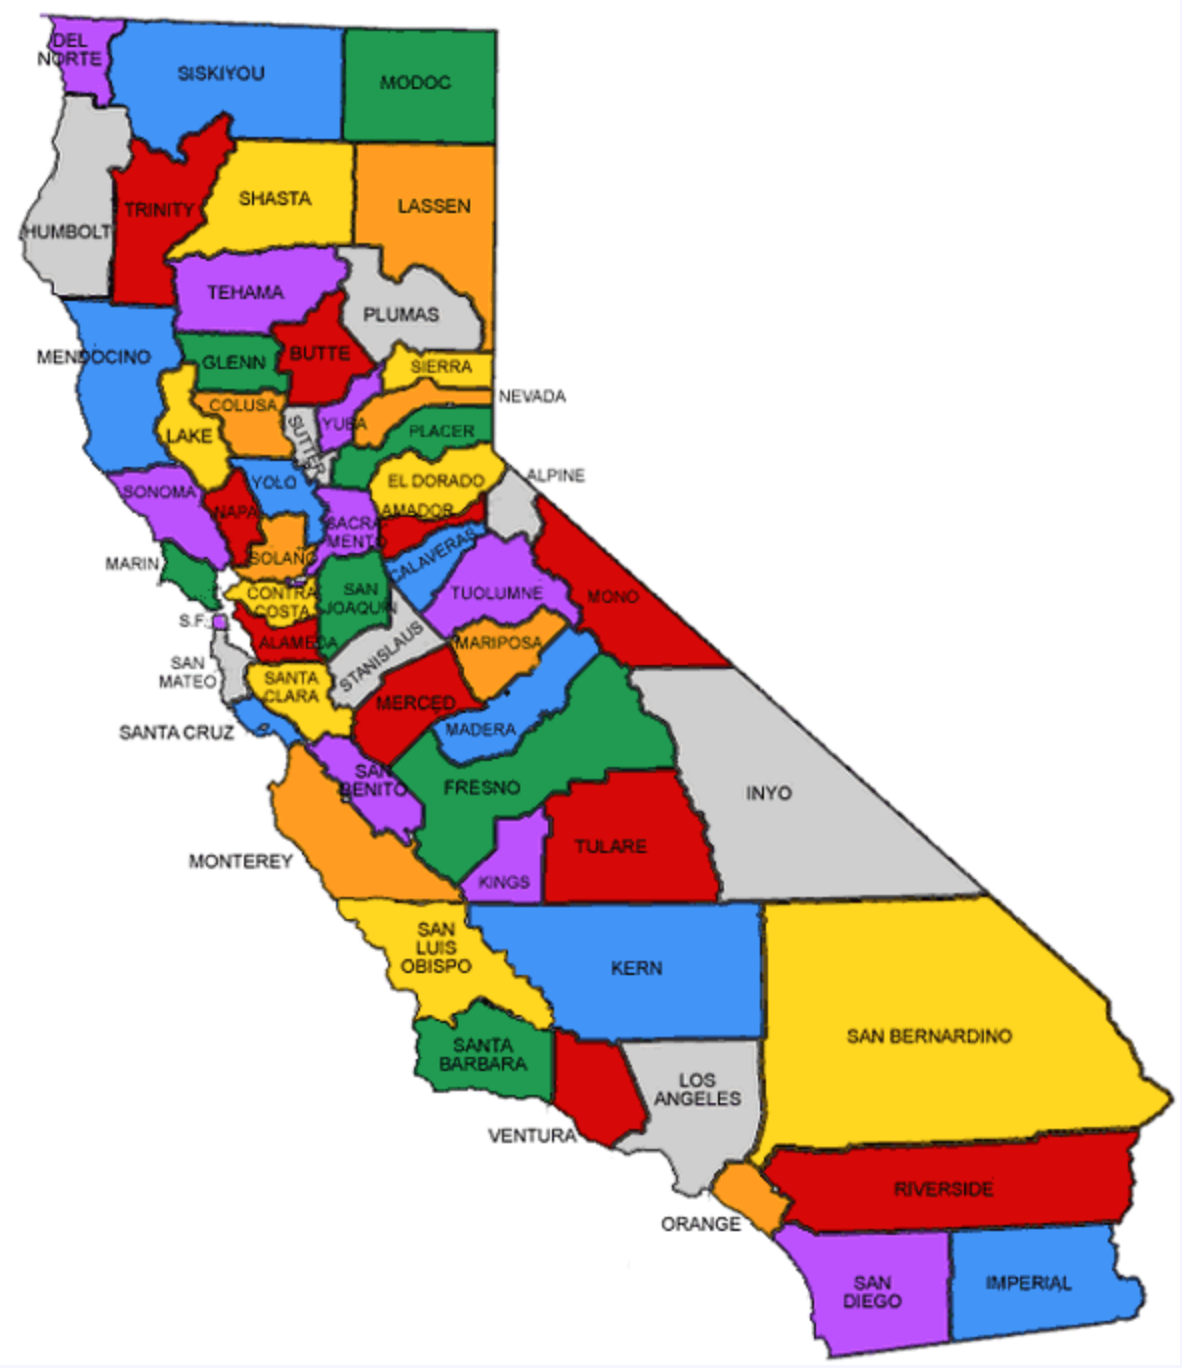

California has a lot of geographical variety: Coastal, Mountain, Desert.  Clearly, different counties will have different rainfall patterns over the months of the year.

Our goal is to predict the probability of rainfall for a day given just two attributes:
1. Which **county** the observation is from
2. Which **month** the observation is from

For example, what is the probability of rain in April in Riverside county?

There are 58 counties and 12 months, for a total of 12 * 58 = 696 different month/county combinations.  So, our "model" is essentially a collection of 696 probability estimates. 

We will judge the quality of our model by calculating the **log_loss** on an independent test set.  Log_loss is also known as **cross-entropy** and is equivalent to using the **maximum-likelihood** principle.  (Log_loss is the negative log likelihood divided by the size of the test set).

## Imports

In [1]:
# If structureboost not already installed, or on google colab
# !pip install structureboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import copy

import structureboost as stb

pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

stb.__version__

'0.0.9'

## Load and Process Data

In [3]:
# If you cloned the repo
df_ca_PRCP = pd.read_csv('../data/CA_County_PRCP.csv')

# If using Google colab try
# df_ca_PRCP = pd.read_csv('https://raw.githubusercontent.com/numeristical/resources/master/data/CA_County_PRCP.csv')

df_ca_PRCP.sample(5)

,county,month,DATE,STATION,PRCP,rained,county_DATE
240515,San_Benito,6,2001-06-06,USC00046926,0.00,0,San_Benito___2001-06-06
54158,Del_Norte,3,2015-03-15,US1CADN0011,0.25,1,Del_Norte___2015-03-15
297780,Santa_Clara,11,2004-11-04,USC00048273,0.08,1,Santa_Clara___2004-11-04
312407,Shasta,2,2009-02-24,USC00047298,0.00,0,Shasta___2009-02-24
31179,Calaveras,1,2008-01-06,USC00041277,1.98,1,Calaveras___2008-01-06


In [4]:
df_ca_PRCP.shape

(415930, 7)

## Data Exploration

The first thing to note, is that we actually have a LOT of data for this problem:
- We are estimating 696 (binomial) probabilities, and have ~600 data points for each county/month combo.
- The events are (mostly) not that rare.
- So, using all of our data, we effectively "know" the right answer to a few percentage points.
- e.g. the standard deviation of the binomial if p=.1 is sqrt(.1 * .9 / 600) = .012

In [5]:
# To get the estimates of the "right" answer using all our data, we can do a simple groupby
mean_by_mc_full = df_ca_PRCP.groupby(['month','county'])['rained'].agg(['mean','count']).reset_index()
mean_by_mc_full.columns = ['month', 'county', 'prob_of_rain', 'num_obs']
mean_by_mc_full.sample(5)

,month,county,prob_of_rain,num_obs
626,11,Siskiyou,0.333333,570
453,8,Solano,0.006791,589
532,10,Glenn,0.132428,589
613,11,Sacramento,0.250877,570
439,8,Sacramento,0.005093,589


Let's first understand the nature of our data before giving details of our modeling problem.

In [6]:
## Let's write a simple function to display the seasonal rain pattern of a given county
def plot_county_rainfalls(target_counties, rain_df):
    for cnty in target_counties:
        small_mean_df = rain_df[rain_df.county==cnty]
        plt.plot(small_mean_df.month, small_mean_df.prob_of_rain, '-o', label=cnty)
        plt.ylim([0,.8])
        plt.xlabel('Month')
        plt.ylabel('Prob of Rainfall')
    plt.legend()  

#### As you can see, there are a variety of seasonal rainfall patterns in the different counties in California

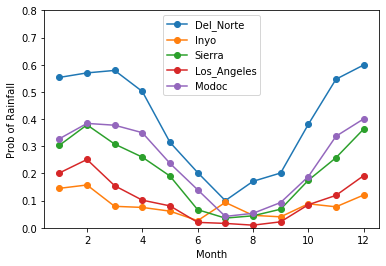

In [7]:
target_counties = ['Del_Norte', 'Inyo', 'Sierra', 'Los_Angeles', 'Modoc']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### But counties in the same regions display similar behavior
### Here are some counties in the Northwest of the state - this is a rainy region

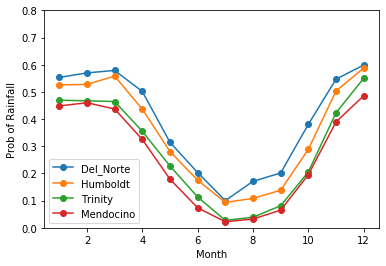

In [8]:
target_counties = ['Del_Norte', 'Humboldt', 'Trinity', 'Mendocino']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Here are counties in the southeast - more of a desert climate

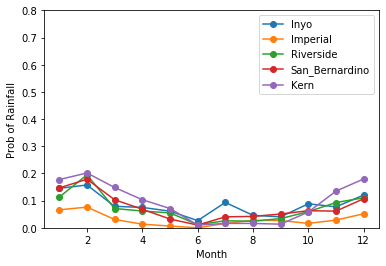

In [9]:
target_counties = ['Inyo', 'Imperial', 'Riverside', 'San_Bernardino', 'Kern']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### In the mountains near the Nevada border

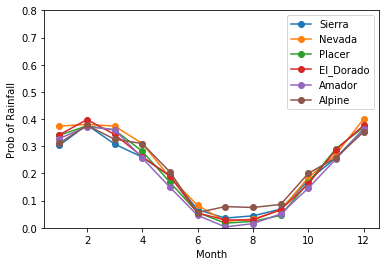

In [10]:
target_counties = ['Sierra', 'Nevada', 'Placer', 'El_Dorado', 'Amador', 'Alpine']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Southern Coastal counties

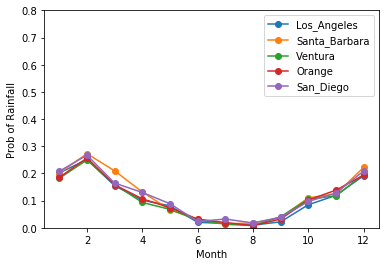

In [11]:
target_counties = ['Los_Angeles', 'Santa_Barbara', 'Ventura', 'Orange', 'San_Diego']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Northeastern counties

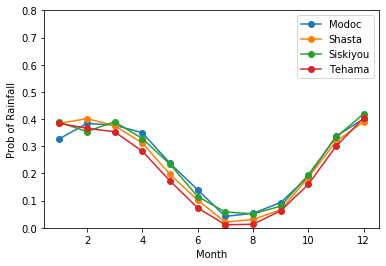

In [12]:
target_counties = ['Modoc', 'Shasta', 'Siskiyou','Tehama']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Though, in some cases, neighboring counties may have quite different patterns

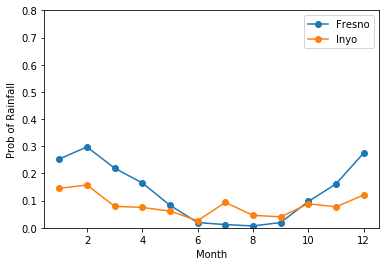

In [13]:
target_counties = ['Fresno', 'Inyo']
plot_county_rainfalls(target_counties, mean_by_mc_full)

### Our Challenge
**Key Observation: With enough data, you don't need really need a model**

We could just compute 696 different means, and if we had enough data on each month/county combination, we would have fairly accurate estimates.

However, what if you only had 1,000 training data points in total?  On average, you would only have 1 or 2 data points per month/county combination.  Taking the mean would give you a terrible estimate.  This is an example of a bias-variance tradeoff.  Broadly speaking, we need to make some assumptions (add bias) to reduce the variance of our estimates.

Speaking more specifically, if I have 500 observations of rain/no rain from Riverside County in April, I can get a good estimate without knowing what other counties are near Riverside, or what other months are "near" April.  But if I have one observation, I will need to know (and exploit) the structure of the counties / months to get a good estimate.


## Brainstorm
How would you attack this problem?

Common approaches:
- Use one-hot encoding (dummy variables) to represent the county.
- Numerical encoding: represent each county by its average rainfall
- Use CatBoost or LightGBM and let the algorithm figure it out

New approach:
- Define the structure of your variables and use StructureBoost

## Set up train, validation, and test sets

In [14]:
## We'll use just two features, county and month
## Target is whether or not it rained
X = df_ca_PRCP.loc[:,['county','month']]
y = df_ca_PRCP.rained.values

In [15]:
X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=1)
X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, test_size = 10000, random_state=1)

In [16]:
num_train_pts = 1000
X_train = X_train_big.iloc[:num_train_pts,:]
y_train = y_train_big[:num_train_pts]

In [17]:
X_train.shape, X_valid.shape, X_test.shape

((1000, 2), (10000, 2), (100000, 2))

## Configuring and Using StructureBoost
StructureBoost has a more complicated configuration than most other boosting packages.  We won't go through all the details now, but here are some important aspects:
- Configuration relies heavily on `feature_configs` - which is passed as a python dictionary
- The keys of the dictionary will be the feature names - when fitting, will look for those names in your `X_train` dataframe
- StructureBoost does **not** define the features by the existence of columns in `X_train` or using any *order* of columns
- Creating the dictionary can be tedious, but there are tools to make it simpler.

In [18]:
# This is a simple function which returns a dict containing default values.
# This dict is *not* the feature_configs, it is used in the `get_basic_config` function
stb.default_config_dict()

{'default_categorical_method': 'span_tree',
 'default_num_span_trees': 1,
 'default_contraction_size': 9,
 'default_contraction_max_splits_to_search': 25,
 'default_numerical_max_splits_to_search': 25}

In [19]:
# This function looks at your training data, and makes some reasonable guesses as to how to configure
# The result can be used as a "starting point" which can be configured further
feature_configs_default = stb.get_basic_config(X_train, stb.default_config_dict())
feature_configs_default

{'county': {'feature_type': 'categorical_str',
  'graph': <graphs.graph_undirected at 0x134b905f8>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

- Note that we have two "keys": `'county'` and `'month'`.
- The corresponding values are dictionaries containing feature-specific configurations


### Defining structure with a graph
- The configuration for a categorical variable must contain a "graph" defining the structure.
- A "graph" here means vertices (dots) and edges (lines connecting pairs of dots).
- When using the `get_basic_config` tool, it will make a "complete" graph. (Every vertex is connected to every other)

In [20]:
default_graph = feature_configs_default['county']['graph']
len(default_graph.vertices), len(default_graph.edges), 58*57/2

(58, 1653, 1653.0)

- To begin, we will just use StructureBoost **without** any knowledge of the counties geography.
- Essentially, it assumes every county borders every other county.
- We will treat month just as a numerical variable.
- Later, we will incorporate the structure and see the improvement.

In [21]:
## We use a large number of trees, and a low_learning rate.  We will rely on early stopping to choose the "right" number of trees
stboost_CA_def = stb.StructureBoost(num_trees = 2000,
                                    learning_rate=.02,
                                    feature_configs=feature_configs_default, 
                                    max_depth=2,
                                    mode='classification')

In [22]:
# We use the `eval_set`, `early_stop_past_steps` and `eval_freq` to define early stopping
stboost_CA_def.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_log_loss = 0.47018127601084786
i=20, eval_set_log_loss = 0.4480711650946989
i=40, eval_set_log_loss = 0.43502747923855156
i=60, eval_set_log_loss = 0.43009621518043134
i=80, eval_set_log_loss = 0.4277833287041385
i=100, eval_set_log_loss = 0.42606762524787073
i=120, eval_set_log_loss = 0.42454608668337923
i=140, eval_set_log_loss = 0.42335287704192187
i=160, eval_set_log_loss = 0.4224353864102753
i=180, eval_set_log_loss = 0.4219469389331842
i=200, eval_set_log_loss = 0.4217816094516651
i=220, eval_set_log_loss = 0.42235030194605605
Stopping early: curr_loss of 0.42235030194605605
                                        exceeds compare_loss of 0.4217816094516651


In [23]:
# Unlike other packages `predict` gives probabilities, not "hard" predictions
pred_probs = stboost_CA_def.predict(X_test)

In [24]:
# We measure our performance using log_loss
stb_default_loss = log_loss(y_test, pred_probs)
stb_default_loss

0.424147430676322

## Incorporate structure of "County" feature
Right now, the county feature is using a *complete* graph, where every vertex is adjacent to every other vertex.  This represents the situation where there is essentially no structure in the different values.


In [25]:
# If you look at the edges, you will see there is an edge for every pair of counties
# whether they are adjacent or not
default_graph.edges

{frozenset({'San_Mateo', 'Solano'}),
 frozenset({'Alpine', 'Mariposa'}),
 frozenset({'Fresno', 'Sutter'}),
 frozenset({'Fresno', 'Glenn'}),
 frozenset({'Lake', 'Riverside'}),
 frozenset({'Alpine', 'Siskiyou'}),
 frozenset({'Contra_Costa', 'San_Benito'}),
 frozenset({'Glenn', 'Lassen'}),
 frozenset({'Monterey', 'San_Luis_Obispo'}),
 frozenset({'San_Bernardino', 'Santa_Barbara'}),
 frozenset({'Tulare', 'Yuba'}),
 frozenset({'San_Francisco', 'Stanislaus'}),
 frozenset({'Mariposa', 'Ventura'}),
 frozenset({'Nevada', 'Tulare'}),
 frozenset({'Trinity', 'Tuolumne'}),
 frozenset({'Nevada', 'San_Luis_Obispo'}),
 frozenset({'Mono', 'Santa_Clara'}),
 frozenset({'Imperial', 'Mendocino'}),
 frozenset({'Riverside', 'Yolo'}),
 frozenset({'Inyo', 'Ventura'}),
 frozenset({'Colusa', 'San_Mateo'}),
 frozenset({'Lassen', 'Santa_Cruz'}),
 frozenset({'Humboldt', 'Yuba'}),
 frozenset({'Humboldt', 'Lake'}),
 frozenset({'Madera', 'Marin'}),
 frozenset({'Inyo', 'Solano'}),
 frozenset({'Fresno', 'Shasta'}),
 fro

In [26]:
# We can build any graph by specifying a set of vertices and edges
my_vertices = ['a','b','c','d']
my_edges = [ ['a','b'],
              ['a','c'],
               ['c','d'],
               ['b','d']]
my_graph = stb.graphs.graph_undirected(edges=my_edges, vertices=my_vertices)
my_graph.vertices, my_graph.edges

({'a', 'b', 'c', 'd'},
 {frozenset({'a', 'b'}),
  frozenset({'c', 'd'}),
  frozenset({'b', 'd'}),
  frozenset({'a', 'c'})})

Let's make a new config that uses the actual CA County adjacency graph. This graph is included in the package, so we don't have to build it from scratch

In [27]:
county_graph = stb.graphs.CA_county_graph()
len(county_graph.vertices), len(county_graph.edges)

(58, 133)

In [28]:
# This graph only has edges between adjacent counties
county_graph.edges

{frozenset({'Fresno', 'San_Benito'}),
 frozenset({'Plumas', 'Shasta'}),
 frozenset({'Sacramento', 'San_Joaquin'}),
 frozenset({'Kings', 'Monterey'}),
 frozenset({'Orange', 'Riverside'}),
 frozenset({'Alpine', 'Mono'}),
 frozenset({'Alameda', 'Contra_Costa'}),
 frozenset({'Butte', 'Yuba'}),
 frozenset({'Lake', 'Napa'}),
 frozenset({'Glenn', 'Mendocino'}),
 frozenset({'Butte', 'Sutter'}),
 frozenset({'Alameda', 'San_Mateo'}),
 frozenset({'Monterey', 'San_Luis_Obispo'}),
 frozenset({'Del_Norte', 'Humboldt'}),
 frozenset({'Del_Norte', 'Siskiyou'}),
 frozenset({'Mariposa', 'Tuolumne'}),
 frozenset({'Kern', 'Tulare'}),
 frozenset({'Fresno', 'Inyo'}),
 frozenset({'Humboldt', 'Trinity'}),
 frozenset({'Sutter', 'Yolo'}),
 frozenset({'Sacramento', 'Sutter'}),
 frozenset({'Kern', 'San_Luis_Obispo'}),
 frozenset({'Riverside', 'San_Bernardino'}),
 frozenset({'Colusa', 'Glenn'}),
 frozenset({'Napa', 'Solano'}),
 frozenset({'Mendocino', 'Trinity'}),
 frozenset({'Alameda', 'Santa_Clara'}),
 frozenset(

In [29]:
# Copy the default configuration, and replace 
# the complete graph (created by the 'get_default_config')
# with the actual CA county graph
feature_configs_1 = copy.deepcopy(feature_configs_default)
feature_configs_1['county']['graph'] = county_graph

In [30]:
feature_configs_1, feature_configs_default

({'county': {'feature_type': 'categorical_str',
   'graph': <graphs.graph_undirected at 0x13510d8d0>,
   'split_method': 'span_tree',
   'num_span_trees': 1},
  'month': {'feature_type': 'numerical', 'max_splits_to_search': 25}},
 {'county': {'feature_type': 'categorical_str',
   'graph': <graphs.graph_undirected at 0x134b905f8>,
   'split_method': 'span_tree',
   'num_span_trees': 1},
  'month': {'feature_type': 'numerical', 'max_splits_to_search': 25}})

In [31]:
len(feature_configs_1['county']['graph'].edges), len(feature_configs_default['county']['graph'].edges)

(133, 1653)

### Run the model with the new config

In [32]:
stboost_CA_1 = stb.StructureBoost(num_trees = 2000,
                                  learning_rate=.02,
                                  feature_configs=feature_configs_1, 
                                  max_depth=2,
                                  mode='classification')

In [33]:
stboost_CA_1.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_log_loss = 0.47018127601084786
i=20, eval_set_log_loss = 0.4468053913805259
i=40, eval_set_log_loss = 0.4335365558097177
i=60, eval_set_log_loss = 0.4273636834401425
i=80, eval_set_log_loss = 0.423728936721646
i=100, eval_set_log_loss = 0.42087179297569194
i=120, eval_set_log_loss = 0.4191176471368749
i=140, eval_set_log_loss = 0.4181866923450686
i=160, eval_set_log_loss = 0.41668669192749813
i=180, eval_set_log_loss = 0.4157233142384879
i=200, eval_set_log_loss = 0.4152336074556996
i=220, eval_set_log_loss = 0.41590682902697346
Stopping early: curr_loss of 0.41590682902697346
                                        exceeds compare_loss of 0.4152336074556996


In [34]:
pred_probs_1 = stboost_CA_1.predict(X_test)

In [35]:
stb_1_loss = log_loss(y_test, pred_probs_1)
stb_1_loss, stb_default_loss

(0.4166123784080873, 0.424147430676322)

### Incorporating structure in the 'month' feature
Previously we treated the month as a numerical variable.  However, doing so ignores
the fact that December is "adjacent" to January in the same way that "July" is
adjacent to "August".  To more accurately model the structure, we will represent the months
by a "cycle" graph

In [36]:
month_graph = stb.graphs.cycle_int_graph(1,12)
month_graph.vertices, month_graph.edges

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 {frozenset({3, 4}),
  frozenset({2, 3}),
  frozenset({11, 12}),
  frozenset({9, 10}),
  frozenset({1, 2}),
  frozenset({4, 5}),
  frozenset({6, 7}),
  frozenset({8, 9}),
  frozenset({7, 8}),
  frozenset({1, 12}),
  frozenset({5, 6}),
  frozenset({10, 11})})

In [37]:
# Copy the previous config, and change the settings for month
feature_configs_2 = copy.deepcopy(feature_configs_1)
feature_configs_2['month']['feature_type'] = 'categorical_int'
feature_configs_2['month']['graph'] = month_graph
feature_configs_2

{'county': {'feature_type': 'categorical_str',
  'graph': <graphs.graph_undirected at 0x134b50860>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <graphs.graph_undirected at 0x134be2a20>}}

In [38]:
feature_configs_2 = stb.apply_defaults(feature_configs_2, stb.default_config_dict())
feature_configs_2
    

{'county': {'feature_type': 'categorical_str',
  'graph': <graphs.graph_undirected at 0x134b50860>,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <graphs.graph_undirected at 0x134be2a20>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [39]:
stboost_CA_2 = stb.StructureBoost(num_trees = 2000,
                                  learning_rate=.02,
                                  feature_configs=feature_configs_2, 
                                  max_depth=2,
                                  mode='classification',
                                  loss_fn='entropy')

In [40]:
stboost_CA_2.fit(X_train, y_train, 
                   eval_set = ((X_valid, y_valid)), 
                   early_stop_past_steps=1, 
                   eval_freq=20)

i=0, eval_set_log_loss = 0.47018127601084786
i=20, eval_set_log_loss = 0.44535067261530686
i=40, eval_set_log_loss = 0.4298352305282178
i=60, eval_set_log_loss = 0.4216844474896736
i=80, eval_set_log_loss = 0.4171108693800631
i=100, eval_set_log_loss = 0.4140587345624314
i=120, eval_set_log_loss = 0.41182383000523604
i=140, eval_set_log_loss = 0.41076406626709533
i=160, eval_set_log_loss = 0.4101041327491839
i=180, eval_set_log_loss = 0.40977320873326645
i=200, eval_set_log_loss = 0.40997873842549926
Stopping early: curr_loss of 0.40997873842549926
                                        exceeds compare_loss of 0.40977320873326645


In [41]:
pred_probs_2 = stboost_CA_2.predict(X_test)

In [42]:
stb_2_loss = log_loss(y_test, pred_probs_2)
stb_2_loss, stb_1_loss, stb_default_loss

(0.4105325593220739, 0.4166123784080873, 0.424147430676322)

## Comparison with CatBoost

In [43]:
import catboost as cb

In [44]:
cat_features = ['county']
cb1 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

In [45]:
cb1.fit(X_train, y_train, cat_features, eval_set=(X_valid, y_valid), verbose=20, early_stopping_rounds=20)

0:	learn: 0.6800843	test: 0.6808077	best: 0.6808077 (0)	total: 52.5ms	remaining: 1m 44s
20:	learn: 0.5083651	test: 0.5202248	best: 0.5202248 (20)	total: 86.8ms	remaining: 8.18s
40:	learn: 0.4430682	test: 0.4651344	best: 0.4651344 (40)	total: 119ms	remaining: 5.69s
60:	learn: 0.4170284	test: 0.4464033	best: 0.4464033 (60)	total: 148ms	remaining: 4.71s
80:	learn: 0.4026624	test: 0.4392829	best: 0.4392829 (80)	total: 176ms	remaining: 4.17s
100:	learn: 0.3939139	test: 0.4352398	best: 0.4352398 (100)	total: 206ms	remaining: 3.87s
120:	learn: 0.3889336	test: 0.4336326	best: 0.4336326 (120)	total: 233ms	remaining: 3.63s
140:	learn: 0.3853050	test: 0.4337330	best: 0.4334711 (135)	total: 267ms	remaining: 3.52s
160:	learn: 0.3820428	test: 0.4332999	best: 0.4329513 (151)	total: 303ms	remaining: 3.46s
180:	learn: 0.3787149	test: 0.4324230	best: 0.4323314 (179)	total: 330ms	remaining: 3.31s
200:	learn: 0.3766398	test: 0.4316215	best: 0.4314119 (192)	total: 358ms	remaining: 3.2s
Stopped by overfitti

In [46]:
pred_probs_cb1 = cb1.predict_proba(X_test)

In [47]:
cb1_loss = log_loss(y_test, pred_probs_cb1)
cb1_loss

0.43366228911560445

In [48]:
cat_features = ['county', 'month']
cb2 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20, max_depth=2,
                             learning_rate=.02, cat_features=cat_features)

In [49]:
cb2.fit(X_train, y_train, cat_features, eval_set=(X_valid, y_valid), verbose=25)

0:	learn: 0.6785215	test: 0.6781298	best: 0.6781298 (0)	total: 3.65ms	remaining: 7.3s
25:	learn: 0.4954996	test: 0.5038773	best: 0.5038773 (25)	total: 57.2ms	remaining: 4.34s
50:	learn: 0.4341599	test: 0.4505046	best: 0.4505046 (50)	total: 98.3ms	remaining: 3.75s
75:	learn: 0.4110045	test: 0.4336122	best: 0.4336122 (75)	total: 133ms	remaining: 3.37s
100:	learn: 0.3987569	test: 0.4267973	best: 0.4267973 (100)	total: 170ms	remaining: 3.19s
125:	learn: 0.3910686	test: 0.4233726	best: 0.4233726 (125)	total: 206ms	remaining: 3.06s
150:	learn: 0.3862382	test: 0.4219087	best: 0.4219087 (150)	total: 249ms	remaining: 3.04s
175:	learn: 0.3828847	test: 0.4221269	best: 0.4218345 (161)	total: 283ms	remaining: 2.93s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4218345396
bestIteration = 161

Shrink model to first 162 iterations.


In [50]:
pred_probs_cb2 = cb2.predict_proba(X_test)

In [51]:
cb2_loss = log_loss(y_test, pred_probs_cb2)
cb2_loss

0.42402658984687347

### Summary of results

In [52]:
print('StructureBoost (w no Structure):             loss = {}'.format(np.round(stb_default_loss, 5)))
print('StructureBoost w County Structure:           loss = {}'.format(np.round(stb_1_loss,5)))
print('StructureBoost w County+Month Structure:     loss = {}'.format(np.round(stb_2_loss,5)))
print('CatBoost:  (County categorical)              loss = {}'.format(np.round(cb1_loss,5)))
print('CatBoost:  (County, Month categorical)       loss = {}'.format(np.round(cb2_loss,5)))

StructureBoost (w no Structure):             loss = 0.42415
StructureBoost w County Structure:           loss = 0.41661
StructureBoost w County+Month Structure:     loss = 0.41053
CatBoost:  (County categorical)              loss = 0.43366
CatBoost:  (County, Month categorical)       loss = 0.42403


## Qualitative Comparison
Let's also look side by side at the predictions made by CatBoost vs StructureBoost and how they compare to the "actuals".


In [53]:
## A function to graph and compare model results to actuals
def compare_models_to_actual(model_list, target_county, rain_df):
  
      small_mean_df = rain_df[rain_df.county==target_county]
      plt.plot(small_mean_df.month, small_mean_df.prob_of_rain, '-o', label='Actual')
      pred_df = pd.DataFrame()
      pred_df['county'] = [target_county]*12
      pred_df['month'] = np.arange(1,13)
      for i,model in enumerate(model_list):
        model_preds = model.predict_proba(pred_df)[:,1]
        plt.plot(np.arange(1,13), model_preds, '-o', label='Model {}'.format(i))

      plt.ylim([0,.8])
      plt.xlabel('Month')
      plt.ylabel('Prob of Rainfall')
      plt.legend()  


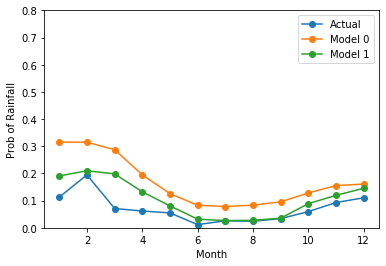

In [54]:
compare_models_to_actual([cb1, stboost_CA_2], 'Riverside', mean_by_mc_full)

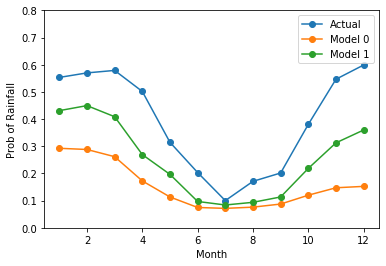

In [55]:
compare_models_to_actual([cb1, stboost_CA_2], 'Del_Norte', mean_by_mc_full)

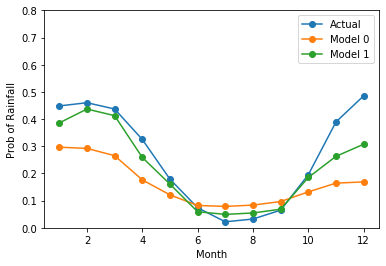

In [56]:
compare_models_to_actual([cb1, stboost_CA_2], 'Mendocino', mean_by_mc_full)

## Repeat multiple trials to show results aren't noise
In case you think the above results are just noise, let's run multiple trials and compare.

In [57]:
num_train_pts = 1000
num_trials = 5
stb_def_loss_vec = np.zeros(num_trials)
stb_1_loss_vec = np.zeros(num_trials)
stb_2_loss_vec = np.zeros(num_trials)
cb1_loss_vec = np.zeros(num_trials)
cb2_loss_vec = np.zeros(num_trials)
stb_def_AUC_vec = np.zeros(num_trials)
stb_1_AUC_vec = np.zeros(num_trials)
stb_2_AUC_vec = np.zeros(num_trials)
cb1_AUC_vec = np.zeros(num_trials)
cb2_AUC_vec = np.zeros(num_trials)
for i in range(num_trials):
    print('Trial {} \n\n'.format(i))
    X_trva, X_test, y_trva, y_test = train_test_split(X,y, test_size = 100000, random_state=i)
    X_train_big, X_valid, y_train_big, y_valid = train_test_split(X_trva, y_trva, 
                                                                  test_size = 10000, random_state=i)
    X_train = X_train_big.iloc[:num_train_pts,:]
    y_train = y_train_big[:num_train_pts]
    

    stboost_CA_def = stb.StructureBoost(num_trees = 2000,
                                        learning_rate=.02,
                                        feature_configs=feature_configs_default, 
                                        max_depth=2,
                                        mode='classification',
                                        random_seed=i)
    stboost_CA_def.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)

    pred_probs_def = stboost_CA_def.predict(X_test)
    stb_def_loss_vec[i] = log_loss(y_test, pred_probs_def)
    stb_def_AUC_vec[i] = roc_auc_score(y_test, pred_probs_def)

    stboost_CA_1 = stb.StructureBoost(num_trees = 2000,
                                      learning_rate=.02,
                                      feature_configs=feature_configs_1, 
                                      max_depth=2,
                                      mode='classification',
                                      random_seed=i)
    stboost_CA_1.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)
    pred_probs_1 = stboost_CA_1.predict(X_test)
    stb_1_loss_vec[i] = log_loss(y_test, pred_probs_1)
    stb_1_AUC_vec[i] = roc_auc_score(y_test, pred_probs_1)
        

    stboost_CA_2 = stb.StructureBoost(num_trees = 2000,
                                      learning_rate=.02,
                                      feature_configs=feature_configs_2, 
                                      max_depth=2,
                                      mode='classification',
                                      random_seed=i)
    stboost_CA_2.fit(X_train, y_train, 
                       eval_set = ((X_valid, y_valid)), 
                       early_stop_past_steps=1, 
                       eval_freq=20)
    pred_probs_2 = stboost_CA_2.predict(X_test)
    stb_2_loss_vec[i] = log_loss(y_test, pred_probs_2)
    stb_2_AUC_vec[i] = roc_auc_score(y_test, pred_probs_2)

    
    cat_features_1 = ['county']
    cb1 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20,
                                max_depth=2,learning_rate=.02,
                                cat_features=cat_features_1, random_seed=i)
    cb1.fit(X_train, y_train, cat_features_1, eval_set=(X_valid, y_valid), verbose=25)
    pred_probs_cb1 = cb1.predict_proba(X_test)
    cb1_loss_vec = log_loss(y_test, pred_probs_cb1)
    cb1_AUC_vec = roc_auc_score(y_test, pred_probs_cb1[:,1])
    
    
    cat_features_2 = ['county', 'month']
    cb2 = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=20,
                                max_depth=2,learning_rate=.02,
                                cat_features=cat_features_2, random_seed=i)

    cb2.fit(X_train, y_train, cat_features_2, eval_set=(X_valid, y_valid), verbose=25)
    pred_probs_cb2 = cb2.predict_proba(X_test)
    cb2_loss_vec[i] = log_loss(y_test, pred_probs_cb2)
    cb2_AUC_vec[i] = roc_auc_score(y_test, pred_probs_cb2[:,1])
    

Trial 0 


i=0, eval_set_log_loss = 0.46881167156787507
i=20, eval_set_log_loss = 0.449372492751091
i=40, eval_set_log_loss = 0.43815706166134216
i=60, eval_set_log_loss = 0.4323959388566624
i=80, eval_set_log_loss = 0.42932521885750985
i=100, eval_set_log_loss = 0.4265574774174386
i=120, eval_set_log_loss = 0.42431755716474806
i=140, eval_set_log_loss = 0.4234725905568775
i=160, eval_set_log_loss = 0.42214415513856973
i=180, eval_set_log_loss = 0.42132342708432435
i=200, eval_set_log_loss = 0.42066103528711335
i=220, eval_set_log_loss = 0.42006353566853033
i=240, eval_set_log_loss = 0.41933361720376916
i=260, eval_set_log_loss = 0.41896656399080484
i=280, eval_set_log_loss = 0.41866394904859405
i=300, eval_set_log_loss = 0.4183936230413892
i=320, eval_set_log_loss = 0.4187208505044805
Stopping early: curr_loss of 0.4187208505044805
                                        exceeds compare_loss of 0.4183936230413892
i=0, eval_set_log_loss = 0.46881167156787507
i=20, eval_set_log_loss = 0

### Summary of results (multiple trials)

In [58]:
print('Average log_loss Scores:')
print('StructureBoost w County+Month Structure:     avg_loss = {}'.format(np.round(np.mean(stb_2_loss_vec),5)))
print('StructureBoost w County Structure:           avg_loss = {}'.format(np.round(np.mean(stb_1_loss_vec),5)))
print('StructureBoost (w no Structure):             avg_loss = {}'.format(np.round(np.mean(stb_def_loss_vec), 5)))
print('CatBoost:  (County categorical)              avg_loss = {}'.format(np.round(np.mean(cb1_loss_vec),5)))
print('CatBoost:  (County, Month categorical)       avg_loss = {}'.format(np.round(np.mean(cb2_loss_vec),5)))
print('\nAverage ROC AUC Scores:')
print('StructureBoost w County+Month Structure:     avg_auc = {}'.format(np.round(np.mean(stb_2_AUC_vec),5)))
print('StructureBoost w County Structure:           avg_auc = {}'.format(np.round(np.mean(stb_1_AUC_vec),5)))
print('StructureBoost (w no Structure):             avg_auc = {}'.format(np.round(np.mean(stb_def_AUC_vec), 5)))
print('CatBoost:  (County categorical)              avg_auc = {}'.format(np.round(np.mean(cb1_AUC_vec),5)))
print('CatBoost:  (County, Month categorical)       avg_auc = {}'.format(np.round(np.mean(cb2_AUC_vec),5)))

Average log_loss Scores:
StructureBoost w County+Month Structure:     avg_loss = 0.40912
StructureBoost w County Structure:           avg_loss = 0.41327
StructureBoost (w no Structure):             avg_loss = 0.41775
CatBoost:  (County categorical)              avg_loss = 0.41762
CatBoost:  (County, Month categorical)       avg_loss = 0.41894

Average ROC AUC Scores:
StructureBoost w County+Month Structure:     avg_auc = 0.75143
StructureBoost w County Structure:           avg_auc = 0.74706
StructureBoost (w no Structure):             avg_auc = 0.73501
CatBoost:  (County categorical)              avg_auc = 0.72849
CatBoost:  (County, Month categorical)       avg_auc = 0.72792


In [59]:
log_loss_diff_vec = cb1_loss_vec-stb_2_loss_vec
log_loss_diff_vec

array([0.01010228, 0.00631205, 0.01013595, 0.00573259, 0.01023062])

In [60]:
## mean and std deviation of log_loss difference
## between StructureBoost and CatBoost
np.mean(log_loss_diff_vec), np.std(log_loss_diff_vec)

(0.00850269840437442, 0.002033930021235366)

In [61]:
# min and max of discrepancy
np.min(log_loss_diff_vec), np.max(log_loss_diff_vec)

(0.005732591502524309, 0.010230621866392065)

In [62]:
roc_auc_score(y_test,pred_probs_2), roc_auc_score(y_test,pred_probs_cb1[:,1])

(0.7509438089213485, 0.7284877050279895)

In [63]:
auc_diff_vec = stb_2_AUC_vec - cb1_AUC_vec
auc_diff_vec

array([0.02681168, 0.02101444, 0.02748986, 0.01694783, 0.0224561 ])

In [64]:
## mean and std deviation of AUC difference
## between StructureBoost and CatBoost
np.mean(auc_diff_vec), np.std(auc_diff_vec)

(0.022943981943616666, 0.003886878700472555)

In [65]:
# min and max of discrepancy
np.min(auc_diff_vec), np.max(auc_diff_vec)

(0.016947826822216627, 0.027489857294245135)